In [1]:
import math
import json
import os
import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta, time
from research.utils.data_access_utils import RDSAccessUtils, S3AccessUtils
from research.weight_estimation.keypoint_utils.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

In [2]:
queryCache = {}

In [173]:
def getPenDF(pen):
    query = """
       SELECT * FROM prod.biomass_computations
        WHERE prod.biomass_computations.captured_at >= '%s'
        AND prod.biomass_computations.captured_at <= '%s'
        AND prod.biomass_computations.pen_id = '%s';
    """ % (pen['start_date'], pen['end_date'], pen['pen_id'])
    
    if query in queryCache:
        df = queryCache[query].copy()
    else:
        df = rds_access_utils.extract_from_database(query)
        queryCache[query] = df.copy()

    df = df.sort_values('captured_at').copy(deep=True)
    df.index = pd.to_datetime(df.captured_at)
    dates = df.index.date.astype(str)
    df['date'] = dates
    df['hour'] = df.index.hour
    
    depths = []
    for idx, row in df.iterrows():
        ann, cm = row.annotation, row.camera_metadata
        wkps = pixel2world(ann['leftCrop'], ann['rightCrop'], cm)
        depth = np.median([wkp[1] for wkp in wkps.values()])
        depths.append(depth)
    df['depth'] = depths
    
    return df
    
# pen1 = {
#     'pen_id': 145,
#     'start_date': '2020-12-01',
#     'end_date': '2021-02-04'
# }

pen1 = {
    'pen_id': 145,
    'start_date': '2021-01-25',
    'end_date': '2021-02-15'
}

df1 = getPenDF(pen1)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/research/weight_estimation/keypoint_utils/optics.py:37: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)


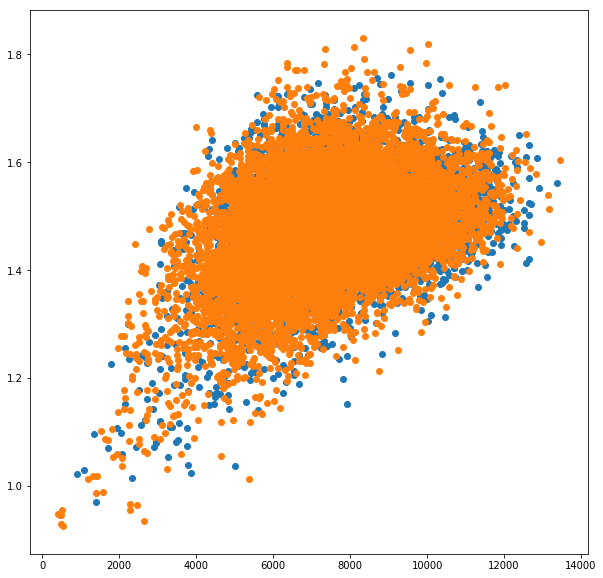

In [174]:
plt.figure(figsize=(10, 10))

df2 = df1[df1.akpd_score > 0.95]

mask1 = df2.captured_at <= '2021-02-04'
mask2 = df2.captured_at >= '2021-02-06'

plt.scatter(df2[mask1].estimated_weight_g, df2[mask1].estimated_k_factor)
plt.scatter(df2[mask2].estimated_weight_g, df2[mask2].estimated_k_factor)

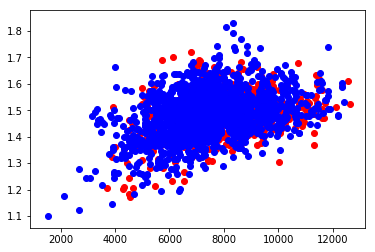

In [219]:
mask3 = (df2.captured_at >= '2021-02-02') & (df2.captured_at < '2021-02-03')
mask4 = (df2.captured_at >= '2021-02-07') & (df2.captured_at < '2021-02-08')

plt.scatter(df2[mask3].estimated_weight_g, df2[mask3].estimated_k_factor, color = 'red')
plt.scatter(df2[mask4].estimated_weight_g, df2[mask4].estimated_k_factor, color = 'blue')

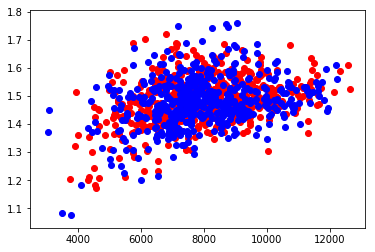

In [220]:
mask3 = (df2.captured_at >= '2021-02-02') & (df2.captured_at < '2021-02-03')
mask4 = (df2.captured_at >= '2021-02-03') & (df2.captured_at < '2021-02-04')

plt.scatter(df2[mask3].estimated_weight_g, df2[mask3].estimated_k_factor, color = 'red')
plt.scatter(df2[mask4].estimated_weight_g, df2[mask4].estimated_k_factor, color = 'blue')

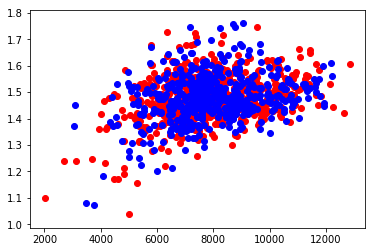

In [221]:
mask3 = (df2.captured_at >= '2021-02-01') & (df2.captured_at < '2021-02-02')
mask4 = (df2.captured_at >= '2021-02-03') & (df2.captured_at < '2021-02-04')

plt.scatter(df2[mask3].estimated_weight_g, df2[mask3].estimated_k_factor, color = 'red')
plt.scatter(df2[mask4].estimated_weight_g, df2[mask4].estimated_k_factor, color = 'blue')

(array([3.92861563e-07, 1.17858469e-06, 2.35716938e-06, 5.50006188e-06,
        6.08935423e-06, 9.82153908e-06, 1.47323086e-05, 2.41609861e-05,
        4.16433257e-05, 7.16972353e-05, 9.74296676e-05, 1.29644316e-04,
        1.71484072e-04, 2.31591891e-04, 2.52609985e-04, 2.68128017e-04,
        2.47306354e-04, 1.94859335e-04, 1.71484072e-04, 1.33572931e-04,
        9.90011139e-05, 7.89651742e-05, 5.55899112e-05, 4.24290488e-05,
        2.49467093e-05, 1.59108933e-05, 7.46436970e-06, 2.55360016e-06,
        1.17858469e-06, 3.92861563e-07]),
 array([  898.36329222,  1314.31654096,  1730.2697897 ,  2146.22303843,
         2562.17628717,  2978.12953591,  3394.08278465,  3810.03603339,
         4225.98928213,  4641.94253087,  5057.89577961,  5473.84902835,
         5889.80227709,  6305.75552583,  6721.70877457,  7137.66202331,
         7553.61527205,  7969.56852078,  8385.52176952,  8801.47501826,
         9217.428267  ,  9633.38151574, 10049.33476448, 10465.28801322,
        10881.24126196

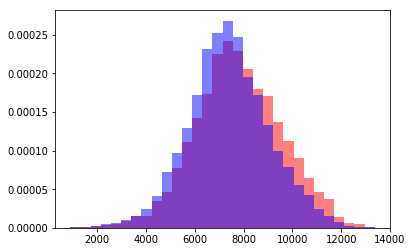

In [14]:
count, bins, _ = plt.hist(df2[mask1].estimated_weight_g, density = True, alpha = 0.5, color = 'red', bins = 30)
plt.hist(df2[mask2].estimated_weight_g, density = True, alpha = 0.5, color = 'blue', bins = bins)

(array([0.00621231, 0.01242462, 0.00621231, 0.02174308, 0.03106155,
        0.02795539, 0.05591079, 0.05901694, 0.08697234, 0.11803388,
        0.28576624, 0.36031396, 0.51251555, 0.82623718, 1.26109886,
        2.15256529, 2.9912271 , 4.11565514, 5.04439544, 5.01022773,
        4.74620457, 3.65905038, 2.60917005, 1.5748205 , 1.0933665 ,
        0.60880635, 0.38826935, 0.10560926, 0.10560926, 0.07454772]),
 array([0.97034717, 0.99669693, 1.0230467 , 1.04939647, 1.07574623,
        1.102096  , 1.12844577, 1.15479554, 1.1811453 , 1.20749507,
        1.23384484, 1.2601946 , 1.28654437, 1.31289414, 1.3392439 ,
        1.36559367, 1.39194344, 1.41829321, 1.44464297, 1.47099274,
        1.49734251, 1.52369227, 1.55004204, 1.57639181, 1.60274158,
        1.62909134, 1.65544111, 1.68179088, 1.70814064, 1.73449041,
        1.76084018]),
 <a list of 30 Patch objects>)

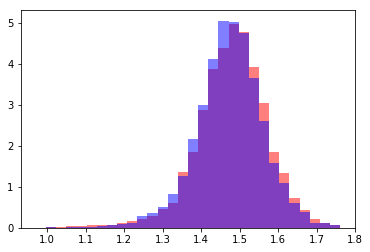

In [15]:
count, bins, _ = plt.hist(df2[mask1].estimated_k_factor, density = True, alpha = 0.5, color = 'red', bins = 30)
plt.hist(df2[mask2].estimated_k_factor, density = True, alpha = 0.5, color = 'blue', bins = bins)

(array([0.        , 0.01321862, 0.05407619, 0.18506074, 0.30282667,
        0.47707217, 0.71140233, 0.98779175, 1.15602879, 1.56820953,
        1.53336043, 1.63069758, 1.67155514, 1.37954371, 1.0671035 ,
        0.84358858, 0.5251399 , 0.30162498, 0.14900995, 0.0696982 ,
        0.05407619, 0.02042878, 0.00961355, 0.00240339, 0.        ,
        0.00240339, 0.        , 0.        , 0.        , 0.        ]),
 array([0.67373991, 0.74169347, 0.80964702, 0.87760057, 0.94555413,
        1.01350768, 1.08146123, 1.14941478, 1.21736834, 1.28532189,
        1.35327544, 1.42122899, 1.48918255, 1.5571361 , 1.62508965,
        1.69304321, 1.76099676, 1.82895031, 1.89690386, 1.96485742,
        2.03281097, 2.10076452, 2.16871807, 2.23667163, 2.30462518,
        2.37257873, 2.44053228, 2.50848584, 2.57643939, 2.64439294,
        2.7123465 ]),
 <a list of 30 Patch objects>)

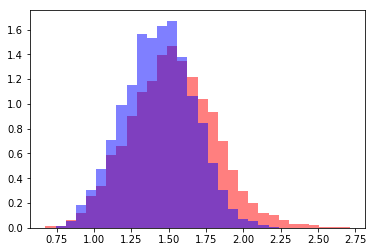

In [16]:
count, bins, _ = plt.hist(df2[mask1].depth, density = True, alpha = 0.5, color = 'red', bins = 30)
plt.hist(df2[mask2].depth, density = True, alpha = 0.5, color = 'blue', bins = bins)

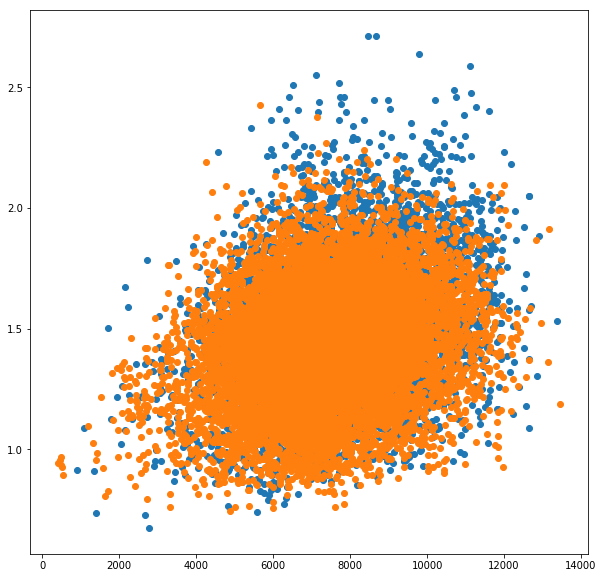

In [10]:
plt.figure(figsize=(10, 10))

plt.scatter(df2[mask1].estimated_weight_g, df2[mask1].depth)
plt.scatter(df2[mask2].estimated_weight_g, df2[mask2].depth)

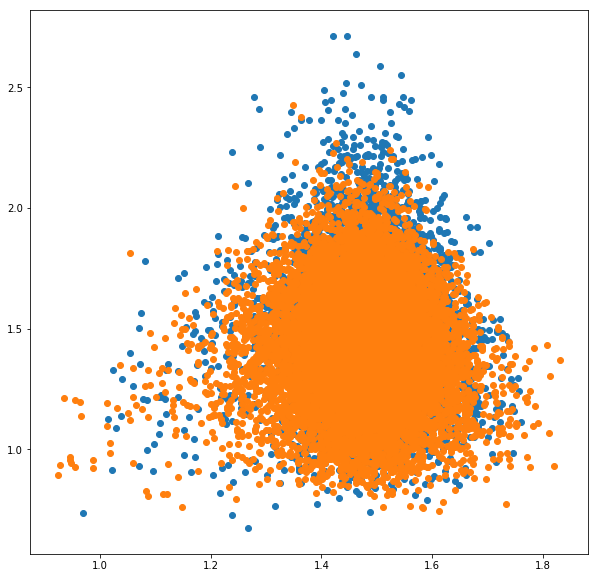

In [11]:
plt.figure(figsize=(10, 10))

plt.scatter(df2[mask1].estimated_k_factor, df2[mask1].depth)
plt.scatter(df2[mask2].estimated_k_factor, df2[mask2].depth)

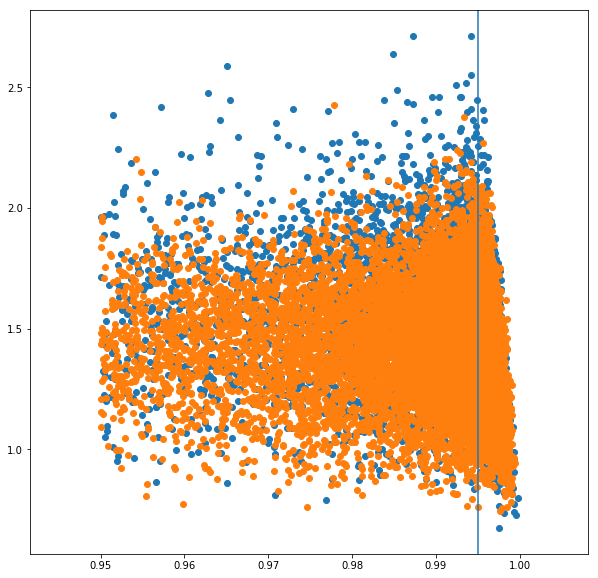

In [223]:
plt.figure(figsize=(10, 10))

plt.scatter(df2[mask1].akpd_score, df2[mask1].depth)
plt.scatter(df2[mask2].akpd_score, df2[mask2].depth)
plt.axvline(0.995)

In [233]:
np.corrcoef(df2[mask1].akpd_score, df2[mask1].depth)

array([[ 1.        , -0.11496487],
       [-0.11496487,  1.        ]])

In [234]:
np.corrcoef(df2[mask2].akpd_score, df2[mask2].depth)

array([[ 1.        , -0.04970153],
       [-0.04970153,  1.        ]])

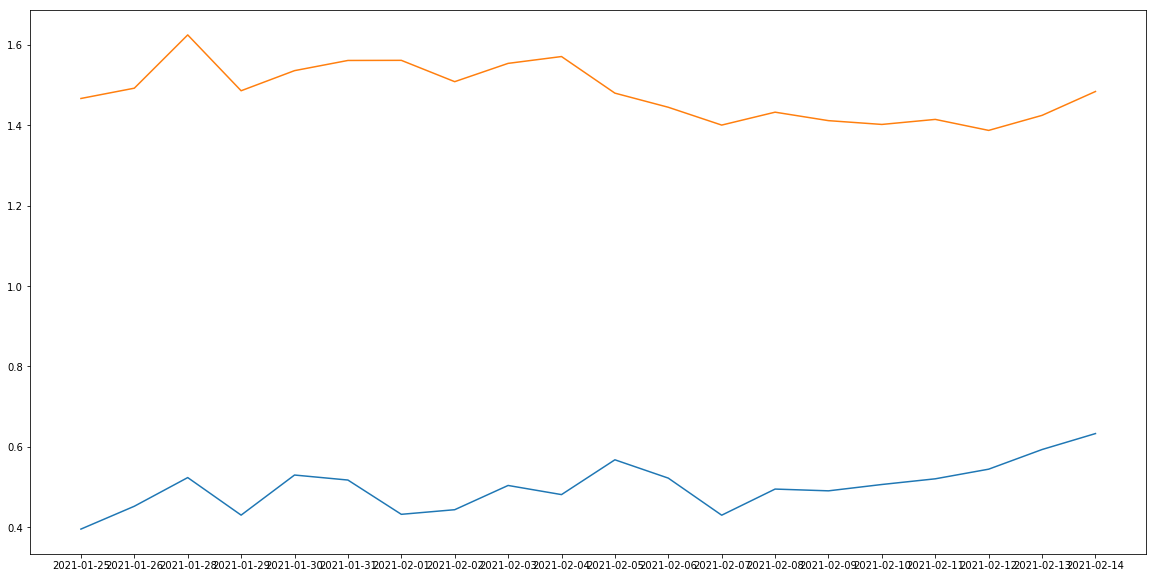

In [252]:
dates = sorted(list(set(df2.date)))

coefs = []
pct1 = []
pct2 = []

for index, date in enumerate(dates):
    df3 = df2[(df2.date <= date) & (df2.date >= dates[max(index - 2, 0)])]
    
    coef = np.corrcoef(df3.akpd_score, df3.depth)[0, 1]
    
    pct1.append(np.sum((df1.akpd_score > 0.95) & (df1.date == date)) / np.sum(df1.date == date))
    pct2.append(np.mean(df2[(df2.date == date)].depth))
    
    
    coefs.append(coef)
    
plt.figure(figsize=(20, 10))

plt.plot(dates, pct1)
plt.plot(dates, pct2)

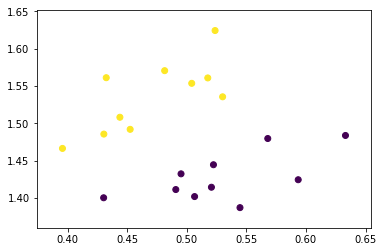

In [257]:
yes = np.array(dates) < '2021-02-05'

plt.scatter(pct1, pct2, c = yes)

(array([0.        , 0.01321862, 0.05407619, 0.18506074, 0.30282667,
        0.47707217, 0.71140233, 0.98779175, 1.15602879, 1.56820953,
        1.53336043, 1.63069758, 1.67155514, 1.37954371, 1.0671035 ,
        0.84358858, 0.5251399 , 0.30162498, 0.14900995, 0.0696982 ,
        0.05407619, 0.02042878, 0.00961355, 0.00240339, 0.        ,
        0.00240339, 0.        , 0.        , 0.        , 0.        ]),
 array([0.67373991, 0.74169347, 0.80964702, 0.87760057, 0.94555413,
        1.01350768, 1.08146123, 1.14941478, 1.21736834, 1.28532189,
        1.35327544, 1.42122899, 1.48918255, 1.5571361 , 1.62508965,
        1.69304321, 1.76099676, 1.82895031, 1.89690386, 1.96485742,
        2.03281097, 2.10076452, 2.16871807, 2.23667163, 2.30462518,
        2.37257873, 2.44053228, 2.50848584, 2.57643939, 2.64439294,
        2.7123465 ]),
 <a list of 30 Patch objects>)

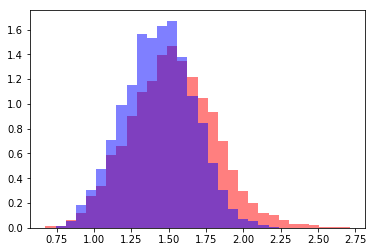

In [231]:
count, bins, _ = plt.hist(df2[mask1].depth, density = True, alpha = 0.5, color = 'red', bins = 30)
plt.hist(df2[mask2].depth, density = True, alpha = 0.5, color = 'blue', bins = bins)

(array([0.02658757, 0.0899887 , 0.20861017, 0.30268927, 0.48880227,
        0.70968363, 0.94079097, 1.1903051 , 1.51753674, 1.53594352,
        1.67910737, 1.62184183, 1.52367234, 1.20257629, 0.97964973,
        0.64832769, 0.43562712, 0.19224859, 0.13089266, 0.06749153,
        0.05112994, 0.02249718, 0.01022599, 0.        , 0.0020452 ,
        0.0020452 , 0.        , 0.        , 0.        , 0.        ]),
 array([0.78684005, 0.8510236 , 0.91520715, 0.9793907 , 1.04357424,
        1.10775779, 1.17194134, 1.23612489, 1.30030844, 1.36449198,
        1.42867553, 1.49285908, 1.55704263, 1.62122618, 1.68540973,
        1.74959327, 1.81377682, 1.87796037, 1.94214392, 2.00632747,
        2.07051101, 2.13469456, 2.19887811, 2.26306166, 2.32724521,
        2.39142875, 2.4556123 , 2.51979585, 2.5839794 , 2.64816295,
        2.7123465 ]),
 <a list of 30 Patch objects>)

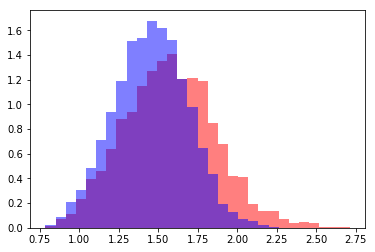

In [229]:
mask1a = mask1 & (df2.akpd_score < 0.995)
mask2a = mask2 & (df2.akpd_score < 0.995)

count, bins, _ = plt.hist(df2[mask1a].depth, density = True, alpha = 0.5, color = 'red', bins = 30)
plt.hist(df2[mask2a].depth, density = True, alpha = 0.5, color = 'blue', bins = bins)

In [81]:
"""
This module contains constants representing core & auxiliary fish body parts.
"""

UPPER_LIP = 'UPPER_LIP'
EYE = 'EYE'
PECTORAL_FIN = 'PECTORAL_FIN'
DORSAL_FIN = 'DORSAL_FIN'
PELVIC_FIN = 'PELVIC_FIN'
ADIPOSE_FIN = 'ADIPOSE_FIN'
ANAL_FIN = 'ANAL_FIN'
TAIL_NOTCH = 'TAIL_NOTCH'
UPPER_PRECAUDAL_PIT = 'UPPER_PRECAUDAL_PIT'
LOWER_PRECAUDAL_PIT = 'LOWER_PRECAUDAL_PIT'
HYPURAL_PLATE = 'HYPURAL_PLATE'

core_body_parts = sorted([UPPER_LIP,
                          EYE,
                          PECTORAL_FIN,
                          DORSAL_FIN,
                          PELVIC_FIN,
                          ADIPOSE_FIN,
                          ANAL_FIN,
                          TAIL_NOTCH])

auxiliary_body_parts = sorted([UPPER_PRECAUDAL_PIT,
                               LOWER_PRECAUDAL_PIT,
                               HYPURAL_PLATE])

all_body_parts = sorted(core_body_parts + auxiliary_body_parts)

In [82]:
"""This module contains utility helper functions for the WeightEstimator class."""

from collections import namedtuple
from typing import Dict, List, Tuple
import numpy as np
import torch


CameraMetadata = namedtuple('CameraMetadata',
                            ['focal_length', 'focal_length_pixel', 'baseline_m',
                             'pixel_count_width', 'pixel_count_height', 'image_sensor_width',
                             'image_sensor_height'])


def get_left_right_keypoint_arrs(annotation: Dict[str, List[Dict]]) -> Tuple:
    """Gets numpy array of left and right keypoints given input keypoint annotation.
    Args:
        annotation: dict with keys 'leftCrop' and 'rightCrop'. Values are lists where each element
        is a dict with keys 'keypointType', 'xCrop' (num pixels from crop left edge),
        'yCrop' (num pixels from crop top edge), 'xFrame' (num pixels from full frame left edge),
        and 'yFrame' (num pixels from full frame top edge).
    Returns:
        X_left: numpy array containing left crop (xFrame, yFrame) for each key-point ordered
        alphabetically.
        X_right: same as above, but for right crop.
    """

    left_keypoints, right_keypoints = {}, {}
    for item in annotation['leftCrop']:
        body_part = item['keypointType']
        left_keypoints[body_part] = (item['xFrame'], item['yFrame'])

    for item in annotation['rightCrop']:
        body_part = item['keypointType']
        right_keypoints[body_part] = (item['xFrame'], item['yFrame'])

    left_keypoint_arr, right_keypoint_arr = [], []
    for body_part in core_body_parts:
        left_keypoint_arr.append(left_keypoints[body_part])
        right_keypoint_arr.append(right_keypoints[body_part])

    X_left = np.array(left_keypoint_arr)
    X_right = np.array(right_keypoint_arr)
    return X_left, X_right


def normalize_left_right_keypoint_arrs(X_left: np.ndarray, X_right: np.ndarray) -> Tuple:
    """Normalizes input left and right key-point arrays. The normalization involves (1) 2D
    translation of all keypoints such that they are centered, (2) rotation of the 2D coordiantes
    about the center such that the line passing through UPPER_LIP and fish center is horizontal.
    """

    # translate key-points, perform reflection if necessary
    upper_lip_idx = core_body_parts.index(UPPER_LIP)
    tail_notch_idx = core_body_parts.index(TAIL_NOTCH)
    if X_left[upper_lip_idx, 0] > X_left[tail_notch_idx, 0]:
        X_center = 0.5 * (np.max(X_left, axis=0) + np.min(X_left, axis=0))
        X_left_centered = X_left - X_center
        X_right_centered = X_right - X_center
    else:
        X_center = 0.5 * (np.max(X_right, axis=0) + np.min(X_right, axis=0))
        X_left_centered = X_right - X_center
        X_right_centered = X_left - X_center
        X_left_centered[:, 0] = -X_left_centered[:, 0]
        X_right_centered[:, 0] = -X_right_centered[:, 0]

    # rotate key-points
    upper_lip_x, upper_lip_y = tuple(X_left_centered[upper_lip_idx])
    theta = np.arctan(upper_lip_y / upper_lip_x)
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    D = X_left_centered - X_right_centered
    X_left_rot = np.dot(X_left_centered, R)
    X_right_rot = X_left_rot - D
    return X_left_rot, X_right_rot


def convert_to_world_point_arr(X_left: np.ndarray, X_right: np.ndarray,
                               camera_metadata: CameraMetadata) -> np.ndarray:
    """Converts input left and right normalized keypoint arrays into world coordinate array."""

    y_world = camera_metadata.focal_length_pixel * camera_metadata.baseline_m / \
              (X_left[:, 0] - X_right[:, 0])

    # Note: the lines commented out below are technically the correct formula for conversion
    # x_world = X_left[:, 0] * y_world / camera_metadata.focal_length_pixel
    # z_world = -X_left[:, 1] * y_world / camera_metadata.focal_length_pixel
    x_world = ((X_left[:, 0] * camera_metadata.image_sensor_width / camera_metadata.pixel_count_width) * y_world) / (camera_metadata.focal_length)
    z_world = (-(X_left[:, 1] * camera_metadata.image_sensor_height / camera_metadata.pixel_count_height) * y_world) / (camera_metadata.focal_length)
    X_world = np.vstack([x_world, y_world, z_world]).T
    return X_world


def stabilize_keypoints(X: np.ndarray) -> np.ndarray:
    """Transforms world coordinate array so that neural network inputs are stabilized"""
    X_new = np.zeros(X.shape)
    X_new[:, 0] = 0.5 * X[:, 0] / X[:, 1]
    X_new[:, 1] = 0.5 * X[:, 2] / X[:, 1]
    X_new[:, 2] = 0.05 / X[:, 1]
    return X_new


def convert_to_nn_input(annotation: Dict[str, List[Dict]], camera_metadata: CameraMetadata) \
        -> torch.Tensor:
    """Convrts input keypoint annotation and camera metadata into neural network tensor input."""
    X_left, X_right = get_left_right_keypoint_arrs(annotation)
    X_left_norm, X_right_norm = normalize_left_right_keypoint_arrs(X_left, X_right)
    X_world = convert_to_world_point_arr(X_left_norm, X_right_norm, camera_metadata)
    X = stabilize_keypoints(X_world)
    nn_input = torch.from_numpy(np.array([X])).float()
    return nn_input

In [83]:
"""
This module contains the WeightEstimator class for estimating fish weight (g), length (mm), and
k-factor given input keypoint coordinates and camera metadata.
"""

from typing import Dict, Tuple
import torch
from torch import nn


class Network(nn.Module):
    """Network class defines neural-network architecture for both weight and k-factor estimation
    (currently both neural networks share identical architecture)."""

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(24, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        """Run inference on input keypoint tensor."""
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.output(x)
        return x


class WeightEstimator:
    """WeightEstimator class is used to predict fish weight, k-factor, and length
    given input keypoint annotations and camera metadata."""

    def __init__(self, weight_model_f: str, kf_model_f: str) -> None:
        """Initializes class with input weight and k-factor neural-networks."""
        self.weight_model = Network()
        self.weight_model.load_state_dict(torch.load(weight_model_f))
        self.weight_model.eval()

        self.kf_model = Network()
        self.kf_model.load_state_dict(torch.load(kf_model_f))
        self.kf_model.eval()

    @staticmethod
    def _get_model_input(annotation: Dict, camera_metadata: CameraMetadata) -> torch.Tensor:
        """Generates neural-network input tensor given annotation and camera_metadata."""
        X = convert_to_nn_input(annotation, camera_metadata)
        return X

    def predict_weight(self, annotation: Dict, camera_metadata: CameraMetadata) -> float:
        """Generates weight prediction given input annotation and camera metadata."""
        X = self._get_model_input(annotation, camera_metadata)
        weight = 1e4 * self.weight_model(X).item()
        return weight

    def predict_kf(self, annotation: Dict, camera_metadata: CameraMetadata) -> float:
        """Generates k-factor prediction gievn input annotation and camera metadata."""
        X = self._get_model_input(annotation, camera_metadata)
        kf = self.kf_model(X).item()
        return kf

    def predict(self, annotation: Dict, camera_metadata: CameraMetadata) -> Tuple:
        """Generates weight, k-factor, and length predictions given input annotation and camera
        metadata."""
        weight = self.predict_weight(annotation, camera_metadata)
        kf = self.predict_kf(annotation, camera_metadata)
        if weight * kf > 0:
            length = (1e5 * weight / kf) ** (1.0 / 3)
        else:
            length = 0
        return weight, length, kf

In [169]:
def load_params(params):
    print("Loading params...")
    cameraMatrix1 = np.array(params['CameraParameters1']['IntrinsicMatrix']).transpose()
    cameraMatrix2 = np.array(params['CameraParameters2']['IntrinsicMatrix']).transpose()

    distCoeffs1 = params['CameraParameters1']['RadialDistortion'][0:2] + \
                   params['CameraParameters1']['TangentialDistortion'] + \
                   [params['CameraParameters1']['RadialDistortion'][2]]
    distCoeffs1 = np.array(distCoeffs1)

    distCoeffs2 = params['CameraParameters2']['RadialDistortion'][0:2] + \
                   params['CameraParameters2']['TangentialDistortion'] + \
                   [params['CameraParameters2']['RadialDistortion'][2]]
    distCoeffs2 = np.array(distCoeffs2)

    R = np.array(params['RotationOfCamera2']).transpose()
    T = np.array(params['TranslationOfCamera2']).transpose()

    imageSize = (4096, 3000)

    # perform rectification
    (R1, R2, P1, P2, Q, leftROI, rightROI) = cv2.stereoRectify(cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, imageSize, R, T, None, None, None, None, None, cv2.CALIB_ZERO_DISPARITY, 0)

    left_maps = cv2.initUndistortRectifyMap(cameraMatrix1, distCoeffs1, R1, P1, imageSize, cv2.CV_16SC2)
    right_maps = cv2.initUndistortRectifyMap(cameraMatrix2, distCoeffs2, R2, P2, imageSize, cv2.CV_16SC2)

    print("Params loaded.")
    return left_maps, right_maps

IMAGE_WIDTH = 4096
IMAGE_HEIGHT = 3000

def get_camera_parameters(params: dict) -> Tuple:
    """Return individual camera parameters from JSON stereo parameters contents."""
    
    cameraMatrix1 = np.array(params['CameraParameters1']['IntrinsicMatrix']).transpose()
    cameraMatrix2 = np.array(params['CameraParameters2']['IntrinsicMatrix']).transpose()

    distCoeffs1 = params['CameraParameters1']['RadialDistortion'][0:2] + \
                   params['CameraParameters1']['TangentialDistortion'] + \
                   [params['CameraParameters1']['RadialDistortion'][2]]
    distCoeffs1 = np.array(distCoeffs1)

    distCoeffs2 = params['CameraParameters2']['RadialDistortion'][0:2] + \
                   params['CameraParameters2']['TangentialDistortion'] + \
                   [params['CameraParameters2']['RadialDistortion'][2]]
    distCoeffs2 = np.array(distCoeffs2)

    R = np.array(params['RotationOfCamera2']).transpose()
    T = np.array(params['TranslationOfCamera2']).transpose()
    
    imageSize = (IMAGE_WIDTH, IMAGE_HEIGHT)
    (R1, R2, P1, P2, Q, leftROI, rightROI) = cv2.stereoRectify(cameraMatrix1, distCoeffs1, cameraMatrix2, 
                                                               distCoeffs2, imageSize, R, T, None, None, 
                                                               None, None, None, cv2.CALIB_ZERO_DISPARITY, 0)
    left_maps = cv2.initUndistortRectifyMap(cameraMatrix1, distCoeffs1, R1, P1, imageSize, cv2.CV_16SC2)
    right_maps = cv2.initUndistortRectifyMap(cameraMatrix2, distCoeffs2, R2, P2, imageSize, cv2.CV_16SC2)
    
    return left_maps, right_maps, cameraMatrix1, distCoeffs1, R1, P1, cameraMatrix2, distCoeffs2, R2, P2

In [170]:
import cv2

s3_access_utils = S3AccessUtils('/root/data', json.load(open(os.environ['AWS_CREDENTIALS'])))

In [188]:
import copy

df3 = df2[mask1]

cm_old = df3.iloc[1].camera_metadata

old_params_f, _, _ = s3_access_utils.download_from_url(cm_old['stereoParametersUrl'])

old_params = json.load(open(old_params_f))

left_maps_m, right_maps_m, cameraMatrix1_m, distCoeffs1_m, R1_m, P1_m, cameraMatrix2_m, distCoeffs2_m, R2_m, P2_m = get_camera_parameters(old_params)
left_maps_c, right_maps_c = right_maps_m, left_maps_m
cameraMatrix1_c, distCoeffs1_c, R1_c, P1_c = cameraMatrix1_m, distCoeffs1_m, R1_m, P1_m
cameraMatrix2_c, distCoeffs2_c, R2_c, P2_c = cameraMatrix2_m, distCoeffs2_m, R2_m, P2_m

weight_model_f = '/root/data/bryton/weight_model_synthetic_data.pb'
kf_model_f = '/root/data/bryton/kf_model.pb'
weight_estimator2 = WeightEstimator(weight_model_f, kf_model_f)

cm_old_adj = CameraMetadata(
    focal_length=cm_old['focalLength'],
    focal_length_pixel=cm_old['focalLengthPixel'],
    baseline_m=cm_old['baseline'],
    pixel_count_width=cm_old['pixelCountWidth'],
    pixel_count_height=cm_old['pixelCountHeight'],
    image_sensor_width=cm_old['imageSensorWidth'],
    image_sensor_height=cm_old['imageSensorHeight']
)

multiple = 0.98

cm_new_adj = CameraMetadata(
    focal_length=cm_old['focalLength'],
    focal_length_pixel=cm_old['focalLengthPixel'],
    baseline_m=cm_old['baseline'] * multiple,
    pixel_count_width=cm_old['pixelCountWidth'],
    pixel_count_height=cm_old['pixelCountHeight'],
    image_sensor_width=cm_old['imageSensorWidth'],
    image_sensor_height=cm_old['imageSensorHeight']
)

cm_new = copy.deepcopy(cm_old)
cm_new['baseline'] = cm_old['baseline'] * multiple

new_keypoints = []
new_weights = []
new_k_factors = []
new_depths = []



for idx, row in df3.iterrows():
    ann_m = row.annotation
    
    # un-rectify with matlab params, re-rectify with circular params
    ann_m_mp_c = {'leftCrop': [], 'rightCrop': []}
    for side in ['leftCrop', 'rightCrop']:
        for item in ann_m[side]:
            bp = item['keypointType']
            x, y = item['xFrame'], item['yFrame']
            if side == 'leftCrop':
                x_new, y_new = cv2.undistortPoints(np.array([[left_maps_m[0][y, x]]]).astype(float), 
                                    cameraMatrix1_c, distCoeffs1_c, R=R1_c, P=P1_c)[0][0]
            elif side == 'rightCrop':
                x_new, y_new = cv2.undistortPoints(np.array([[right_maps_m[0][y, x]]]).astype(float), 
                                    cameraMatrix2_c, distCoeffs2_c, R=R2_c, P=P2_c)[0][0]
            x_new, y_new = int(round(x_new)), int(round(y_new))
            ann_m_mp_c[side].append({
                'keypointType': bp,
                'xFrame': x_new,
                'yFrame': y_new
            })
            
    new_keypoints.append(ann_m_mp_c)
    
    new_weight, new_length, new_k_factor = weight_estimator2.predict(ann_m_mp_c, cm_new_adj)
    
    wkps = pixel2world(ann_m_mp_c['leftCrop'], ann_m_mp_c['rightCrop'], cm_new)
    depth = np.median([wkp[1] for wkp in wkps.values()])
    new_depths.append(depth)
    
    new_weights.append(new_weight)
    new_k_factors.append(new_k_factor)
    
df3['new_keypoints'] = new_keypoints
df3['new_weights'] = new_weights
df3['new_k_factors'] = new_k_factors
df3['new_depths'] = new_depths

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

(array([1.33784994e-06, 8.91899957e-07, 2.67569987e-06, 4.45949979e-06,
        8.02709962e-06, 7.58114964e-06, 1.78379991e-05, 2.54191488e-05,
        4.45949979e-05, 6.73384468e-05, 1.06582045e-04, 1.39136393e-04,
        1.65893392e-04, 2.30110189e-04, 2.57313138e-04, 2.42596788e-04,
        2.28326389e-04, 1.94880141e-04, 1.69460992e-04, 1.35122844e-04,
        1.09703695e-04, 8.25007461e-05, 6.10951471e-05, 4.23652480e-05,
        3.52300483e-05, 1.29325494e-05, 6.24329970e-06, 4.01354981e-06,
        4.45949979e-07, 0.00000000e+00]),
 array([  898.36329222,  1314.31654096,  1730.2697897 ,  2146.22303843,
         2562.17628717,  2978.12953591,  3394.08278465,  3810.03603339,
         4225.98928213,  4641.94253087,  5057.89577961,  5473.84902835,
         5889.80227709,  6305.75552583,  6721.70877457,  7137.66202331,
         7553.61527205,  7969.56852078,  8385.52176952,  8801.47501826,
         9217.428267  ,  9633.38151574, 10049.33476448, 10465.28801322,
        10881.24126196

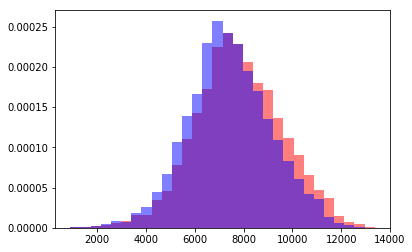

In [197]:
count, bins, _ = plt.hist(df3.estimated_weight_g, density = True, alpha = 0.5, color = 'red', bins = 30)
plt.hist(df3['new_weights'], density = True, alpha = 0.5, color = 'blue', bins = bins)

In [190]:
np.mean(df3['new_weights']), np.mean(df3.estimated_weight_g)

(7408.395853122967, 7797.713036391917)

(array([0.        , 0.01407939, 0.04223817, 0.03519848, 0.04927787,
        0.04927787, 0.06335726, 0.09151604, 0.11967483, 0.20415118,
        0.20415118, 0.3308657 , 0.4998184 , 0.76028714, 1.4853758 ,
        1.99223389, 2.85811646, 4.20269835, 4.37869074, 5.11785879,
        4.67435796, 3.90703113, 2.73844164, 1.68248728, 1.16154979,
        0.66877109, 0.34494509, 0.14079391, 0.09151604, 0.04223817]),
 array([0.97034717, 0.99669693, 1.0230467 , 1.04939647, 1.07574623,
        1.102096  , 1.12844577, 1.15479554, 1.1811453 , 1.20749507,
        1.23384484, 1.2601946 , 1.28654437, 1.31289414, 1.3392439 ,
        1.36559367, 1.39194344, 1.41829321, 1.44464297, 1.47099274,
        1.49734251, 1.52369227, 1.55004204, 1.57639181, 1.60274158,
        1.62909134, 1.65544111, 1.68179088, 1.70814064, 1.73449041,
        1.76084018]),
 <a list of 30 Patch objects>)

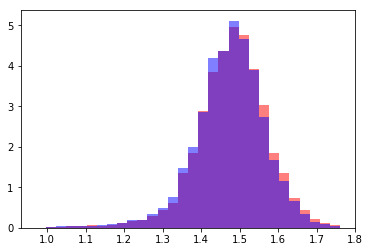

In [198]:
count, bins, _ = plt.hist(df3.estimated_k_factor, density = True, alpha = 0.5, color = 'red', bins = 30)
plt.hist(df3['new_k_factors'], density = True, alpha = 0.5, color = 'blue', bins = bins)

In [192]:
np.mean(df3['new_k_factors']), np.mean(df3.estimated_k_factor)

(1.4732804750852309, 1.479441618729239)

(array([0.00818917, 0.02183778, 0.07643223, 0.16378335, 0.26205336,
        0.4613231 , 0.56505256, 0.77524119, 1.01545677, 1.11645651,
        1.37305042, 1.43856376, 1.53410405, 1.22837513, 1.1273754 ,
        1.09461873, 0.73702508, 0.62510645, 0.35486393, 0.29481003,
        0.1337564 , 0.09827001, 0.09008084, 0.03821612, 0.03275667,
        0.03002695, 0.00818917, 0.00272972, 0.00272972, 0.00545945]),
 array([0.67373991, 0.74169347, 0.80964702, 0.87760057, 0.94555413,
        1.01350768, 1.08146123, 1.14941478, 1.21736834, 1.28532189,
        1.35327544, 1.42122899, 1.48918255, 1.5571361 , 1.62508965,
        1.69304321, 1.76099676, 1.82895031, 1.89690386, 1.96485742,
        2.03281097, 2.10076452, 2.16871807, 2.23667163, 2.30462518,
        2.37257873, 2.44053228, 2.50848584, 2.57643939, 2.64439294,
        2.7123465 ]),
 <a list of 30 Patch objects>)

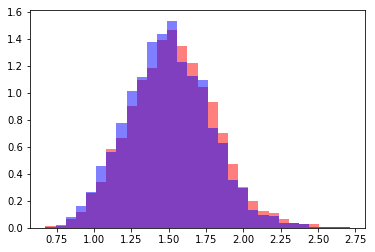

In [199]:
count, bins, _ = plt.hist(df3.depth, density = True, alpha = 0.5, color = 'red', bins = 30)
plt.hist(df3['new_depths'], density = True, alpha = 0.5, color = 'blue', bins = bins)

In [194]:
np.mean(df3['new_depths']), np.mean(df3.depth)

(1.4979252876089393, 1.528496363447151)

In [114]:
np.mean(df2[mask1].estimated_weight_g), np.mean(df2[mask2].estimated_weight_g)

(7797.713036391917, 7398.346541384024)

In [137]:
np.mean(df2[mask1].estimated_weight_g), np.mean(samples)

(7797.713036391917, 7390.914493000719)

In [142]:
np.mean(df2[mask1].estimated_k_factor), np.mean(df2[mask2].estimated_k_factor), np.mean(kfs)

(1.479441618729239, 1.473150100020554, 1.4745292053341865)

In [143]:
np.mean(df2[mask1].depth), np.mean(df2[mask2].depth), np.mean(depths)

(1.528481483442261, 1.4326207526619703, 1.510784578993569)

(array([2.40435677e-07, 1.44261406e-06, 1.44261406e-06, 2.40435677e-06,
        5.53002057e-06, 9.61742708e-06, 1.77922401e-05, 3.55844802e-05,
        4.85680068e-05, 6.61198112e-05, 1.00982984e-04, 1.40174000e-04,
        1.85616343e-04, 2.07255554e-04, 2.33463042e-04, 2.51014847e-04,
        2.35626964e-04, 2.07736425e-04, 1.82731115e-04, 1.40174000e-04,
        1.10840847e-04, 8.41524870e-05, 5.33767203e-05, 3.60653516e-05,
        2.06774682e-05, 1.22622195e-05, 6.49176328e-06, 3.12566380e-06,
        2.64479245e-06, 9.61742708e-07]),
 array([  898.36329222,  1314.31654096,  1730.2697897 ,  2146.22303843,
         2562.17628717,  2978.12953591,  3394.08278465,  3810.03603339,
         4225.98928213,  4641.94253087,  5057.89577961,  5473.84902835,
         5889.80227709,  6305.75552583,  6721.70877457,  7137.66202331,
         7553.61527205,  7969.56852078,  8385.52176952,  8801.47501826,
         9217.428267  ,  9633.38151574, 10049.33476448, 10465.28801322,
        10881.24126196

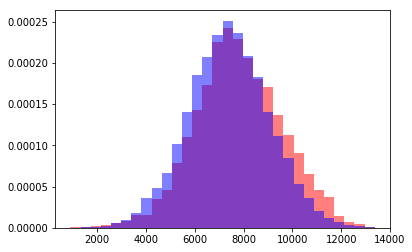

In [201]:
# samples = np.random.normal(np.mean(df2[mask2].estimated_weight_g), np.std(df2[mask2].estimated_weight_g), 10000)
count, bins, _ = plt.hist(df2[mask1].estimated_weight_g, density = True, alpha = 0.5, color = 'red', bins = 30)
plt.hist(samples, density = True, alpha = 0.5, color = 'blue', bins = bins)

In [134]:
kfs = [ df2[mask1].iloc[(df2[mask1]['estimated_weight_g'] - w).abs().argsort()[0]]['estimated_k_factor'] for w in samples ]
depths = [ df2[mask1].iloc[(df2[mask1]['estimated_weight_g'] - w).abs().argsort()[0]]['depth'] for w in samples ]


(array([0.0075902 , 0.0075902 , 0.0265657 , 0.0341559 , 0.0531314 ,
        0.037951  , 0.1024677 , 0.151804  , 0.0910824 , 0.2504766 ,
        0.265657  , 0.341559  , 0.53890419, 0.58824049, 1.49906449,
        1.97724708, 2.90325147, 3.99624026, 4.25430706, 5.02850745,
        4.59966116, 3.74576367, 3.01710447, 1.78749208, 1.19166139,
        0.69450329, 0.4022806 , 0.1821648 , 0.1062628 , 0.0683118 ]),
 array([0.97034717, 0.99669693, 1.0230467 , 1.04939647, 1.07574623,
        1.102096  , 1.12844577, 1.15479554, 1.1811453 , 1.20749507,
        1.23384484, 1.2601946 , 1.28654437, 1.31289414, 1.3392439 ,
        1.36559367, 1.39194344, 1.41829321, 1.44464297, 1.47099274,
        1.49734251, 1.52369227, 1.55004204, 1.57639181, 1.60274158,
        1.62909134, 1.65544111, 1.68179088, 1.70814064, 1.73449041,
        1.76084018]),
 <a list of 30 Patch objects>)

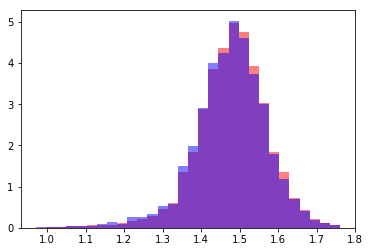

In [204]:
count, bins, _ = plt.hist(df3.estimated_k_factor, density = True, alpha = 0.5, color = 'red', bins = 30)
plt.hist(kfs, density = True, alpha = 0.5, color = 'blue', bins = bins)

(array([1.47159341e-02, 1.61875275e-02, 8.97671977e-02, 1.39801373e-01,
        3.03148241e-01, 3.92915439e-01, 5.87165769e-01, 7.37268296e-01,
        9.12387911e-01, 1.03894494e+00, 1.20229181e+00, 1.45982066e+00,
        1.54811626e+00, 1.36858187e+00, 1.20229181e+00, 1.01392786e+00,
        8.31450274e-01, 7.22552362e-01, 3.78199505e-01, 2.76659560e-01,
        1.58932088e-01, 7.79944505e-02, 1.10369505e-01, 6.76932966e-02,
        1.47159341e-02, 1.61875275e-02, 1.61875275e-02, 1.47159341e-03,
        7.35796703e-03, 8.82956043e-03]),
 array([0.67373991, 0.74169347, 0.80964702, 0.87760057, 0.94555413,
        1.01350768, 1.08146123, 1.14941478, 1.21736834, 1.28532189,
        1.35327544, 1.42122899, 1.48918255, 1.5571361 , 1.62508965,
        1.69304321, 1.76099676, 1.82895031, 1.89690386, 1.96485742,
        2.03281097, 2.10076452, 2.16871807, 2.23667163, 2.30462518,
        2.37257873, 2.44053228, 2.50848584, 2.57643939, 2.64439294,
        2.7123465 ]),
 <a list of 30 Patch obj

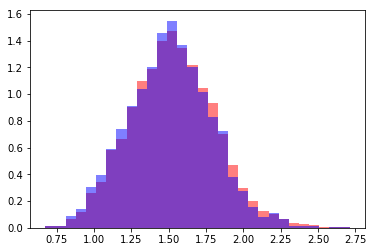

In [205]:
count, bins, _ = plt.hist(df3.depth, density = True, alpha = 0.5, color = 'red', bins = 30)
plt.hist(depths, density = True, alpha = 0.5, color = 'blue', bins = bins)

(array([7.21234901e-07, 1.44246980e-06, 1.20205817e-06, 2.88493960e-06,
        5.04864430e-06, 1.03377002e-05, 2.25986936e-05, 1.77904609e-05,
        4.42357406e-05, 5.86604386e-05, 9.83283581e-05, 1.29581870e-04,
        1.69730613e-04, 2.13485531e-04, 2.45700689e-04, 2.53634273e-04,
        2.10841003e-04, 1.69249790e-04, 1.69249790e-04, 1.54825092e-04,
        1.26456519e-04, 9.32797138e-05, 6.25070247e-05, 5.33713826e-05,
        4.44761522e-05, 2.35603401e-05, 1.39438747e-05, 4.32740940e-06,
        2.64452797e-06, 0.00000000e+00]),
 array([  898.36329222,  1314.31654096,  1730.2697897 ,  2146.22303843,
         2562.17628717,  2978.12953591,  3394.08278465,  3810.03603339,
         4225.98928213,  4641.94253087,  5057.89577961,  5473.84902835,
         5889.80227709,  6305.75552583,  6721.70877457,  7137.66202331,
         7553.61527205,  7969.56852078,  8385.52176952,  8801.47501826,
         9217.428267  ,  9633.38151574, 10049.33476448, 10465.28801322,
        10881.24126196

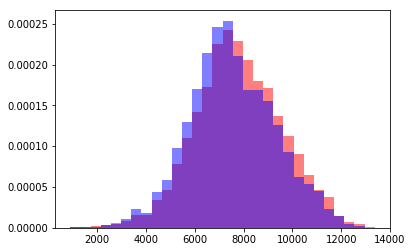

In [207]:
depth_samples = np.random.normal(np.mean(df2[mask2].depth), np.std(df2[mask2].depth), 10000)
depth_kfs = [ df2[mask1].iloc[(df2[mask1]['depth'] - d).abs().argsort()[0]]['estimated_k_factor'] for d in depth_samples ]
depth_weights = [ df2[mask1].iloc[(df2[mask1]['depth'] - d).abs().argsort()[0]]['estimated_weight_g'] for d in depth_samples ]


count, bins, _ = plt.hist(df2[mask1].estimated_weight_g, density = True, alpha = 0.5, color = 'red', bins = 30)
plt.hist(depth_weights, density = True, alpha = 0.5, color = 'blue', bins = bins)

(array([0.0113853 , 0.0151804 , 0.0265657 , 0.0872873 , 0.0189755 ,
        0.037951  , 0.0683118 , 0.0872873 , 0.0796971 , 0.1821648 ,
        0.189755  , 0.2960178 , 0.2884276 , 0.4971581 , 1.33587519,
        1.64707338, 2.86909557, 3.71160777, 4.31123356, 4.59966116,
        4.81218676, 3.76094407, 3.46492627, 1.78749208, 1.36623599,
        0.93738969, 0.73624939, 0.4022806 , 0.2163207 , 0.1062628 ]),
 array([0.97034717, 0.99669693, 1.0230467 , 1.04939647, 1.07574623,
        1.102096  , 1.12844577, 1.15479554, 1.1811453 , 1.20749507,
        1.23384484, 1.2601946 , 1.28654437, 1.31289414, 1.3392439 ,
        1.36559367, 1.39194344, 1.41829321, 1.44464297, 1.47099274,
        1.49734251, 1.52369227, 1.55004204, 1.57639181, 1.60274158,
        1.62909134, 1.65544111, 1.68179088, 1.70814064, 1.73449041,
        1.76084018]),
 <a list of 30 Patch objects>)

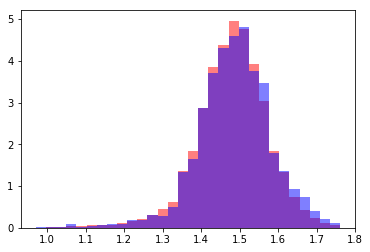

In [210]:
count, bins, _ = plt.hist(df3.estimated_k_factor, density = True, alpha = 0.5, color = 'red', bins = 30)
plt.hist(kfs, density = True, alpha = 0.5, color = 'blue', bins = bins)

(array([1.61940051e-02, 3.23880101e-02, 6.47760202e-02, 1.61940051e-01,
        2.41437894e-01, 4.19571949e-01, 7.21369316e-01, 9.40724476e-01,
        1.22485566e+00, 1.51487556e+00, 1.71656454e+00, 1.72686981e+00,
        1.56492976e+00, 1.33379714e+00, 1.06291560e+00, 7.86145336e-01,
        5.41763078e-01, 3.20935737e-01, 1.73717509e-01, 9.42196658e-02,
        3.38601924e-02, 1.61940051e-02, 1.47218228e-03, 4.41654683e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([0.67373991, 0.74169347, 0.80964702, 0.87760057, 0.94555413,
        1.01350768, 1.08146123, 1.14941478, 1.21736834, 1.28532189,
        1.35327544, 1.42122899, 1.48918255, 1.5571361 , 1.62508965,
        1.69304321, 1.76099676, 1.82895031, 1.89690386, 1.96485742,
        2.03281097, 2.10076452, 2.16871807, 2.23667163, 2.30462518,
        2.37257873, 2.44053228, 2.50848584, 2.57643939, 2.64439294,
        2.7123465 ]),
 <a list of 30 Patch obj

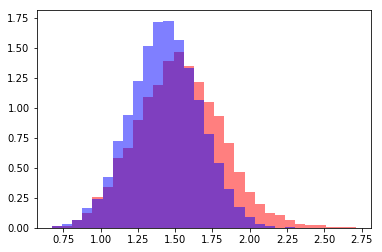

In [211]:
count, bins, _ = plt.hist(df2[mask1].depth, density = True, alpha = 0.5, color = 'red', bins = 30)
plt.hist(depth_samples, density = True, alpha = 0.5, color = 'blue', bins = bins)